# Exercise 1.3

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [4]:
batch_size = 64
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
# trainset = datasets.MNIST('./data', train=True, download=True, transform=custom_transforms)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:18<00:00, 9013497.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


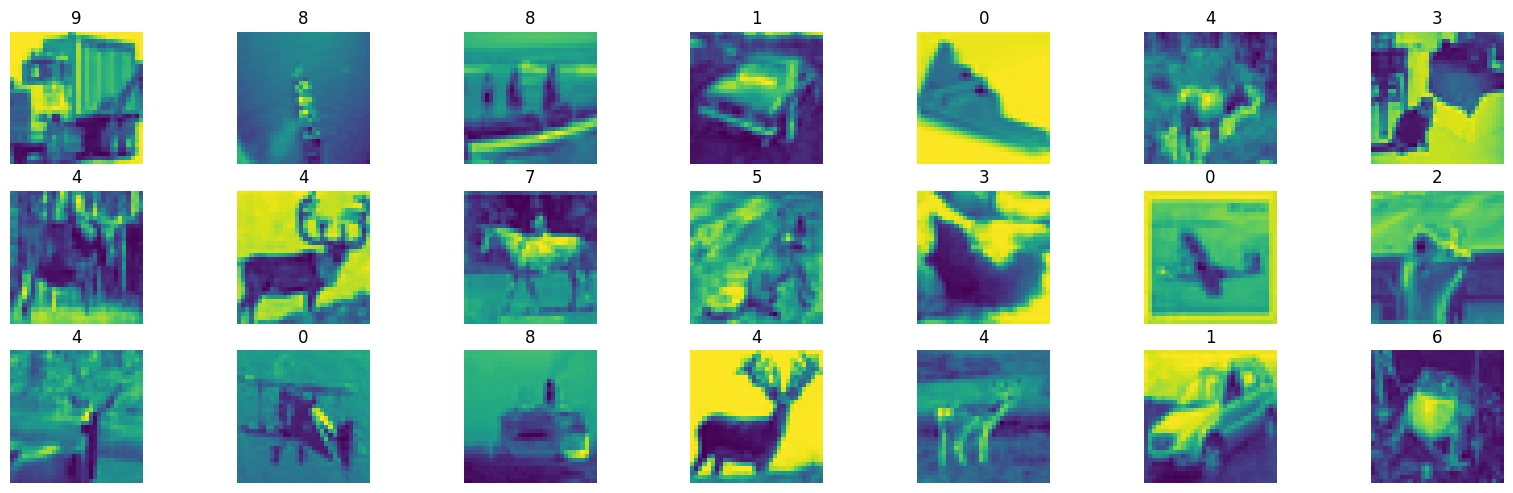

In [13]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[2])
    plt.title(labels[i].item())
    plt.axis('off')

* Make a CNN to train on the CIFAR10 dataset

In [45]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 8, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(8, 3, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(3, 3, 3, stride=1, padding=1),
                nn.ReLU(),
                )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*16*3, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))

    def forward(self, x):

        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x

In [46]:
model = Network()
model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters())

In [47]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [48]:
out_dict = train(model, optimizer)
# ...
# ...
# plt.legend(('Test error','Train eror'))
# plt.xlabel('Epoch number')
# plt.ylabel('Accuracy')

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.914	 test: 1.712	 Accuracy train: 27.9%	 test: 35.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.657	 test: 1.620	 Accuracy train: 38.2%	 test: 39.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.539	 test: 1.462	 Accuracy train: 43.1%	 test: 46.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.430	 test: 1.390	 Accuracy train: 47.7%	 test: 49.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.358	 test: 1.411	 Accuracy train: 50.7%	 test: 49.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.294	 test: 1.290	 Accuracy train: 53.5%	 test: 53.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.234	 test: 1.248	 Accuracy train: 56.0%	 test: 54.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.185	 test: 1.217	 Accuracy train: 57.6%	 test: 56.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.143	 test: 1.190	 Accuracy train: 59.3%	 test: 57.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.115	 test: 1.183	 Accuracy train: 60.4%	 test: 57.9%


In [49]:
def plot_metrics(out_dict):
    epochs = range(1, len(out_dict['train_acc']) + 1)

    # Plotting the training and testing loss
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, out_dict['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, out_dict['test_loss'], 'r-', label='Testing Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, out_dict['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, out_dict['test_acc'], 'r-', label='Testing Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

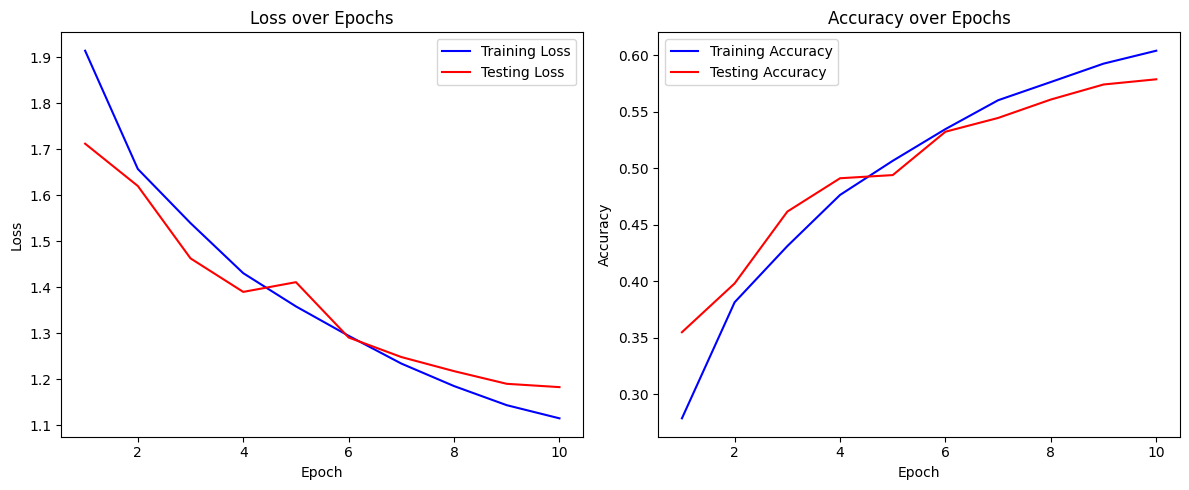

In [50]:
plot_metrics(out_dict)

Text(0, 0.5, 'Accuracy')

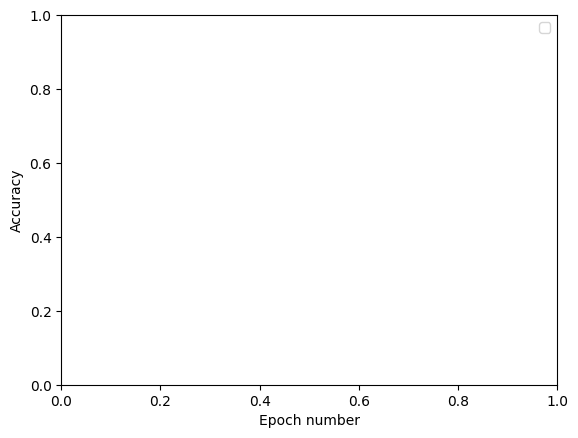

In [51]:
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [64]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()

        self.convolutional = nn.Sequential(
                nn.Conv2d(n_features, n_features, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(n_features, n_features, 3, stride=1, padding=1),
                nn.ReLU(),
                )

    def forward(self, x):

        conv_output = self.convolutional(x)

        out = conv_output + x

        out = F.relu(out)

        return out

The following code is a sanity of your residual block network

In [65]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

Passed sanity check


We define a network that uses your `ResNetBlock`

In [66]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.Softmax(dim=1))

    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [67]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.852	 test: 2.011	 Accuracy train: 33.2%	 test: 30.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.459	 test: 1.469	 Accuracy train: 47.9%	 test: 47.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.286	 test: 1.409	 Accuracy train: 53.9%	 test: 50.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.149	 test: 1.408	 Accuracy train: 59.1%	 test: 50.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.001	 test: 1.409	 Accuracy train: 64.1%	 test: 51.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.829	 test: 1.367	 Accuracy train: 70.6%	 test: 54.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.621	 test: 1.485	 Accuracy train: 78.3%	 test: 54.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.427	 test: 1.885	 Accuracy train: 84.9%	 test: 53.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.293	 test: 1.828	 Accuracy train: 89.7%	 test: 56.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 16.6%	 test: 10.0%


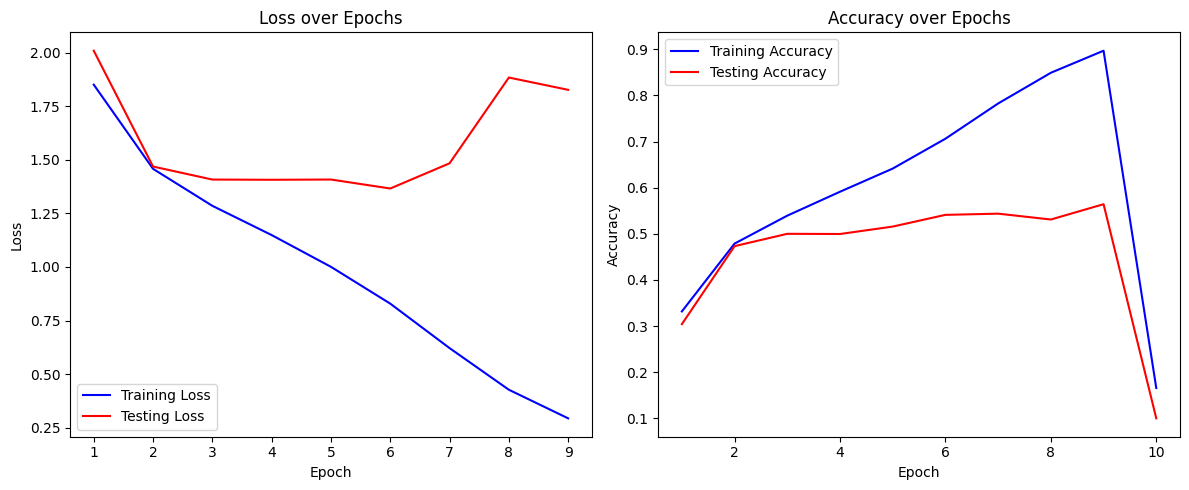

In [68]:
plot_metrics(out_dict)



Do you get nan loss at some point during training?
This can be caused by the numerical instability of using softmax and log as two functions.
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.